# Gibbs Sampling

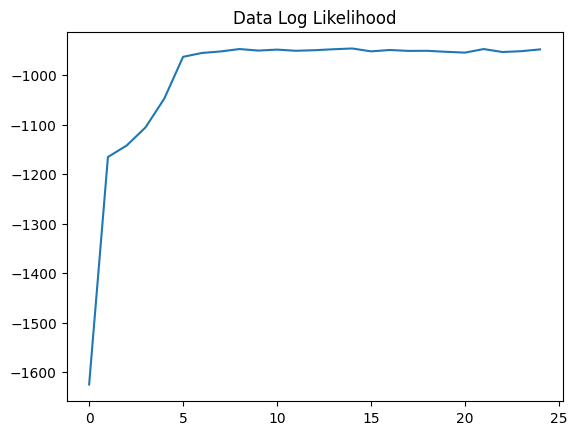

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from scipy.stats import dirichlet, multivariate_normal
from pathlib import Path
from IPython.display import HTML

# Data.
with open("data/hw1_250.txt", "r") as f:
    x = np.array([[float(i) for i in line.split()] for line in f.read().split("\n") if line])

# Init.
N = len(x)
K = 3

pi_prior = dirichlet(alpha=[1, 1, 1])
pi = pi_prior.rvs()[0]

z = np.random.choice(a=np.arange(K), size=N, p=pi)

mu_prior = multivariate_normal(mean=[0, 0], cov=10)
mu = mu_prior.rvs(size=K)

K_COLORS = ["red", "green", "blue"]
def plot_clusters(x, z, mu, ax):
    frame = []
    for k in range(K):
        mask = z == k
        frame.append(ax.scatter(x[mask, 0], x[mask, 1], c=K_COLORS[k], alpha=0.8))
    for k in range(K):
        frame.append(ax.scatter(mu[k, 0], mu[k, 1], c=K_COLORS[k], marker="^", s=200, linewidths=3, edgecolor="black"))
    return frame

# Sample.
fig, ax = plt.subplots()
frames = []
log_likelihoods = []

for step in range(25):
    frames.append(plot_clusters(x, z, mu, ax))

    # z.
    dist = ((x - mu[:, None, :]) ** 2).sum(axis=-1)
    unnorm_p = pi[:, None] * np.exp(-0.5 * dist)
    p = unnorm_p / unnorm_p.sum(axis=0)

    cum_probs = np.cumsum(p, axis=0)
    rand = np.random.random(cum_probs.shape[1])
    z = (rand >= cum_probs).sum(axis=0)

    # pi
    n = (z[:, None] == np.arange(K)).sum(axis=0)
    pi = np.random.dirichlet(n + 1)

    # mu
    empirical_mean = np.array([x[z == k].sum(axis=0) for k in range(K)])
    mu_new = empirical_mean / (0.1 + n[:, None])
    sigma_new = 1 / (0.1 + n)
    mu = np.array([multivariate_normal.rvs(mean=mu_new[k], cov=sigma_new[k]) for k in range(K)])

    # calc log prob of data
    lp_pi = pi_prior.logpdf(pi)
    lp_mu = mu_prior.logpdf(mu).sum()
    lp_z = np.log(pi)[z].sum()

    lp_x = sum(multivariate_normal.logpdf(x[z == k], mean=mu[k], cov=1).sum() for k in range(K))
    lp_data = lp_pi + lp_mu + lp_z + lp_x
    log_likelihoods.append(lp_data)

frames.append(plot_clusters(x, z, mu, ax))
anim = ArtistAnimation(fig, frames, interval=300, blit=True)
output_dir = Path("outputs")
output_dir.mkdir(exist_ok=True)
anim.save(output_dir / "gibbs.mp4", writer="ffmpeg")
plt.close(fig)

ll_fig, ll_ax = plt.subplots()
ll_ax.plot(log_likelihoods)
ll_ax.set_title("Data Log Likelihood")
plt.show()

HTML(anim.to_jshtml())

# Variational Inference

In [2]:
from scipy.special import digamma

# Init.
# NOTE: phi = 1/K -> no symmetry breaking, nothing learned
r = np.random.random((N, K))
phi = r / r.sum(axis=-1, keepdims=True)

# VI.
fig, ax = plt.subplots()
frames = []

for step in range(20):
    # gamma.
    s_phi = phi.sum(axis=0)
    gamma = 1 + s_phi

    # m, sigma.
    sigma = 1 / (0.1 + s_phi)
    m = (x[:, None, :] * phi[:, :, None]).sum(axis=0) * sigma[:, None]

    # phi.
    dist = ((x[:, None, :] - m) ** 2).sum(axis=-1)
    l = digamma(gamma) - digamma(gamma.sum()) - (0.5 * dist)
    l = l - l.max(axis=-1, keepdims=True)
    exp_l = np.exp(l)
    phi = exp_l / exp_l.sum(axis=-1, keepdims=True)

    # Plot.
    z = phi.argmax(axis=-1)
    frames.append(plot_clusters(x, z, m, ax))

anim = ArtistAnimation(fig, frames, interval=300, blit=True)
anim.save(output_dir / "vi.mp4", writer="ffmpeg")
plt.close(fig)

HTML(anim.to_jshtml())